In [ ]:
!pip install optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm,font_manager
import matplotlib as mat
import matplotlib.pyplot as plt

# font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/Arial.ttf").get_name()
# font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/NANUMBARUNPENR.TTF").get_name()

def setPlotStyle():    
    plt.figure(dpi=300)  
    # mat.rcParams['font.family'] = font_name
    mat.rcParams['font.size'] = 15
    mat.rcParams['legend.fontsize'] = 15
    mat.rcParams['lines.linewidth'] = 2
    mat.rcParams['lines.color'] = 'r'
    mat.rcParams['axes.grid'] = 1     
    mat.rcParams['axes.xmargin'] = 0.1     
    mat.rcParams['axes.ymargin'] = 0.1     
    mat.rcParams["mathtext.fontset"] = "dejavuserif" #"cm", "stix", etc.
    mat.rcParams['figure.dpi'] = 500
    mat.rcParams['savefig.dpi'] = 500
setPlotStyle()

<Figure size 1800x1200 with 0 Axes>

In [ ]:
model_baseline = joblib.load('/content/drive/MyDrive/SSU데이터톤/최종_코드/model/study.pkl')
model_SVDpp = joblib.load('/content/drive/MyDrive/SSU데이터톤/최종_코드/model/study2.pkl')
uir_df = pd.read_csv('/content/drive/MyDrive/SSU데이터톤/최종_코드/data/final_uir_df.csv')

In [ ]:
new_df = pd.read_csv('/content/drive/MyDrive/SSU데이터톤/new_df.csv')
bookloan = pd.read_csv('/content/drive/MyDrive/SSU데이터톤/데이터_단행본대출.csv',encoding = 'cp949')
bookres = pd.read_csv('/content/drive/MyDrive/SSU데이터톤/데이터_단행본예약.csv',encoding = 'cp949')
enter = pd.read_csv('/content/drive/MyDrive/SSU데이터톤/데이터_도서관출입.csv',encoding = 'cp949')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 도서관 연도별 출입

In [ ]:
inter = enter.copy()

In [ ]:
inter['year'] = pd.DatetimeIndex(inter['출입일시']).year
inter['year'].value_counts().reset_index

<bound method Series.reset_index of 2017    2331378
2018    2185199
2019    2172662
2021     657108
2020     570019
2022      47885
Name: year, dtype: int64>

In [ ]:
a=pd.DataFrame(inter['year'].value_counts())
a.reset_index(inplace = True)
a.columns = ['year','entrance']

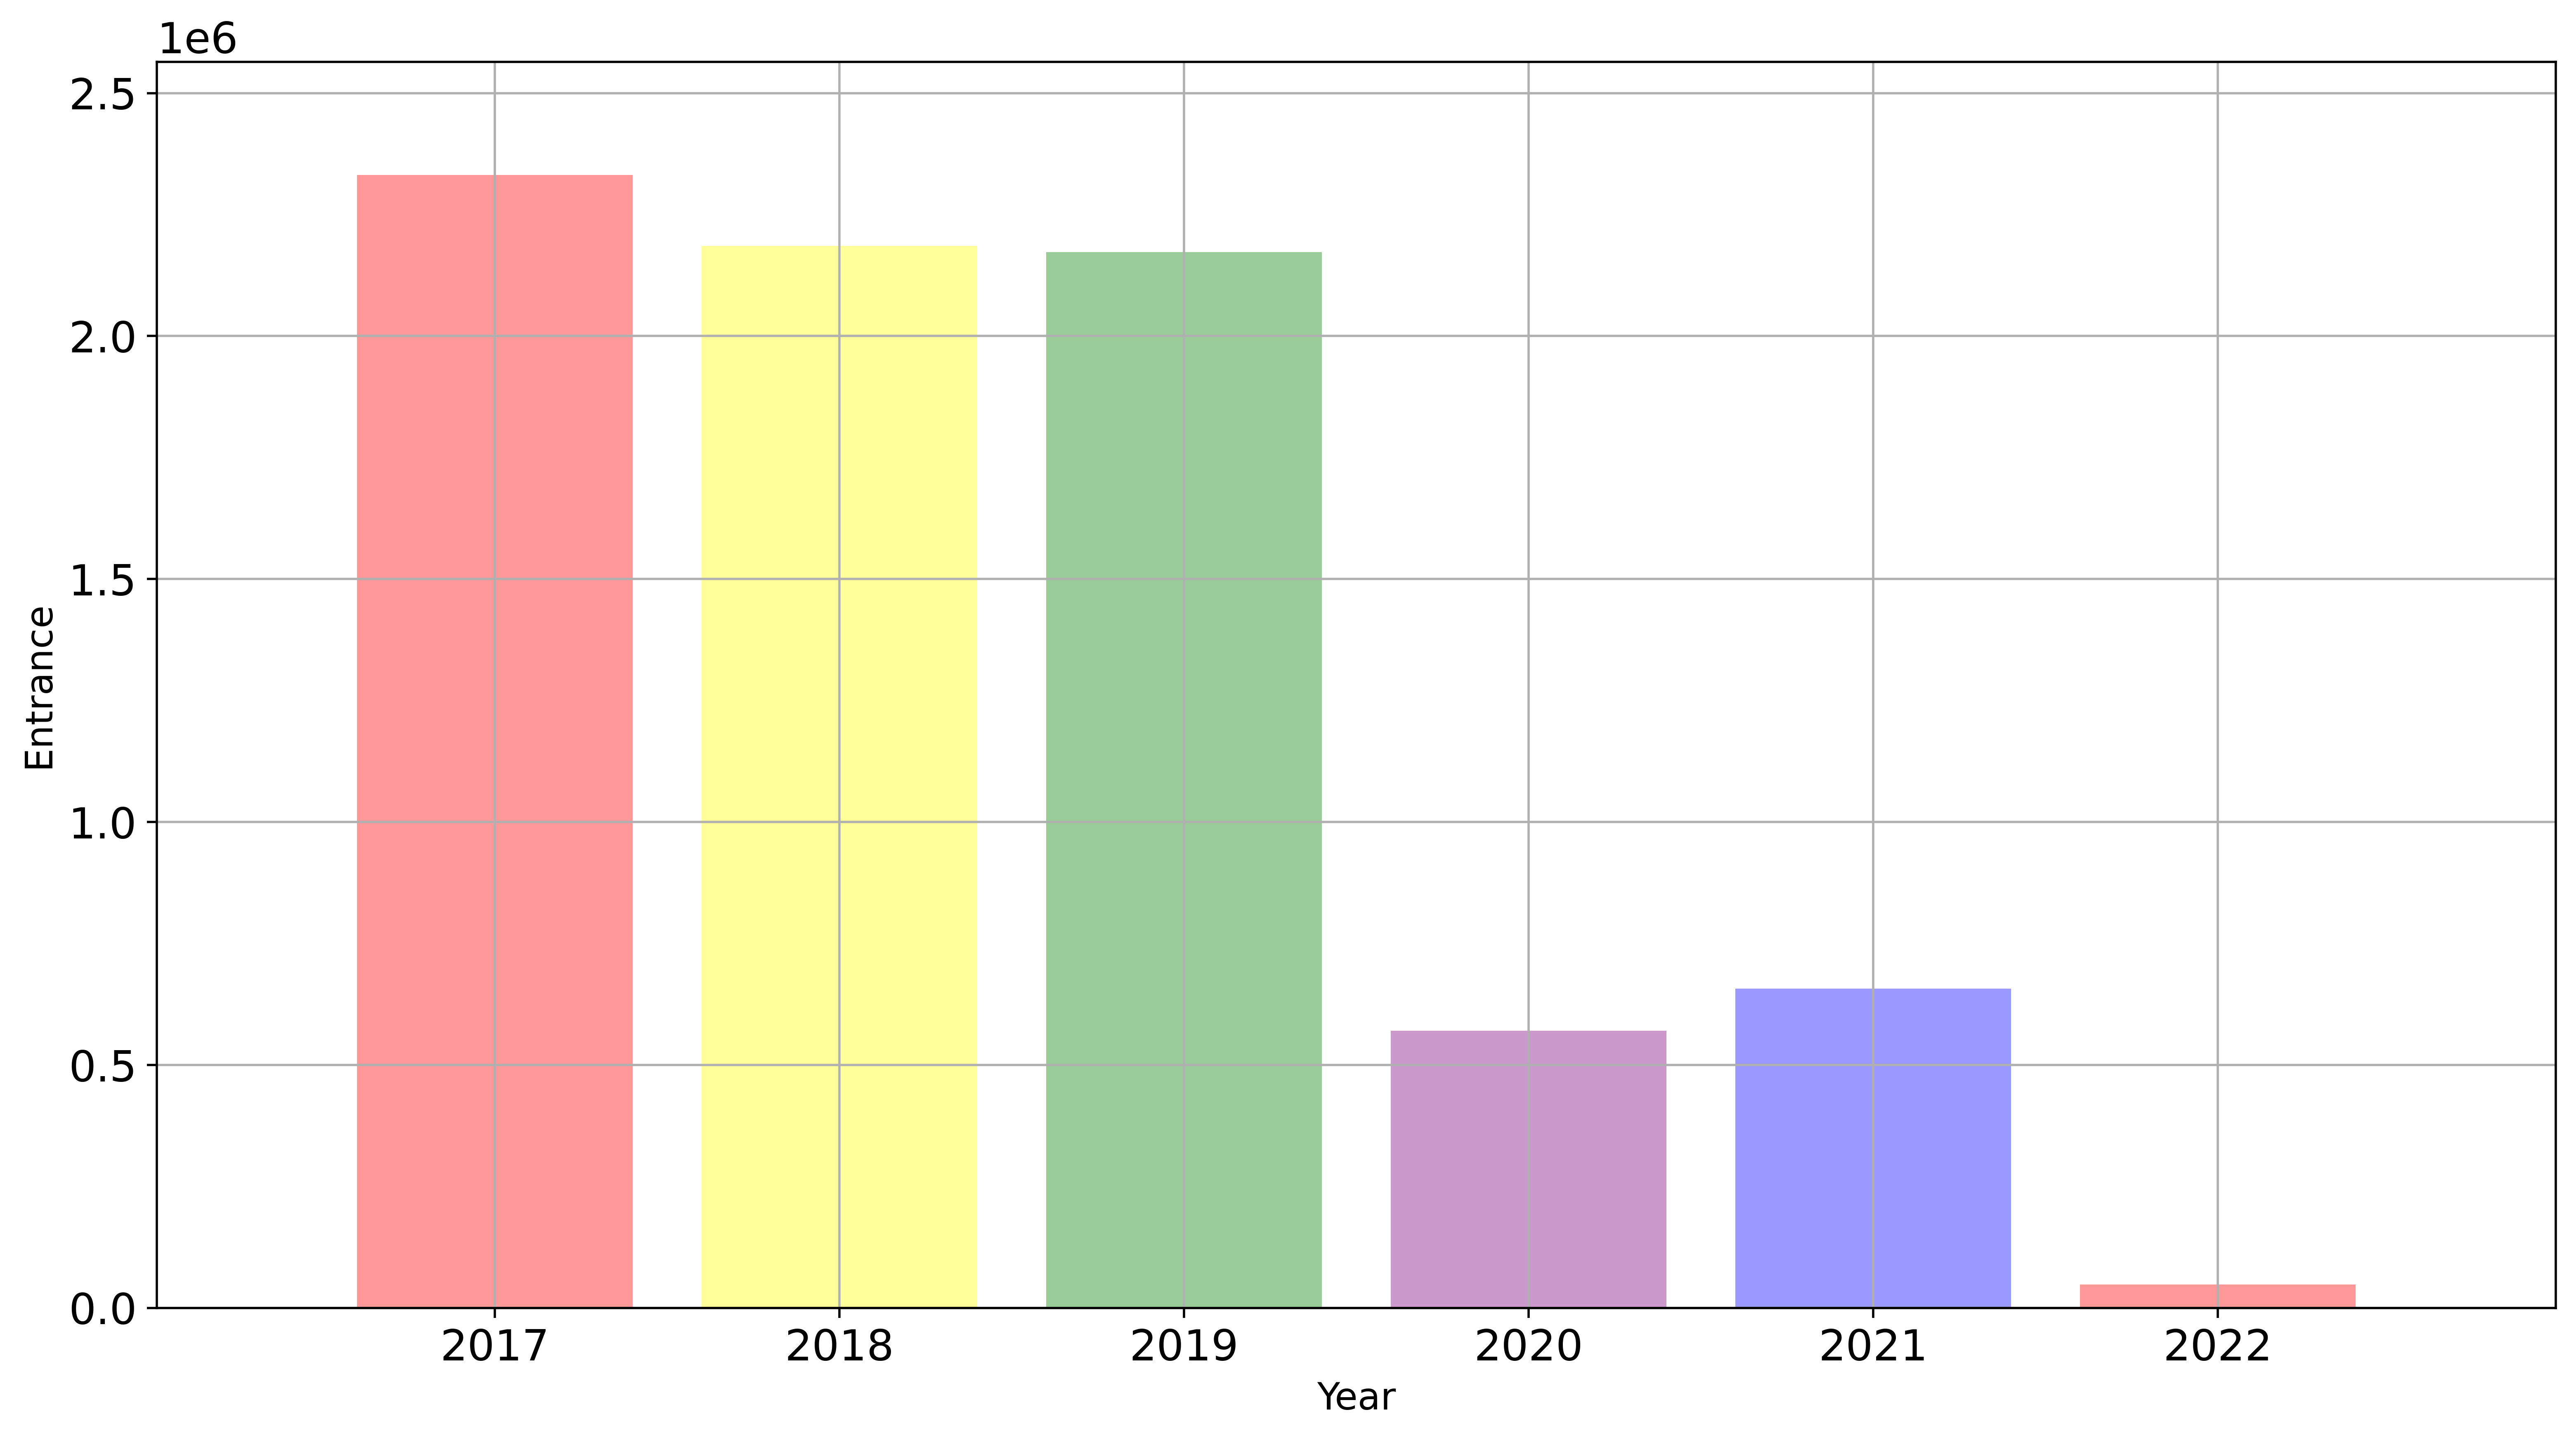

In [ ]:
plt.figure(figsize = (15,8))
plt.bar(a['year'],a['entrance'],color = ['red','yellow','green','blue','purple'],alpha = 0.4)
plt.xlabel('Year', size = 13)
plt.ylabel('Entrance', size = 13)
plt.show()

## 도서관 연도별 대출

In [ ]:
bookloan['year'] = pd.DatetimeIndex(bookloan['대출일시']).year

In [ ]:
b = pd.DataFrame(bookloan['year'].value_counts())
b.reset_index(inplace = True)
b.columns = ['year','loan']

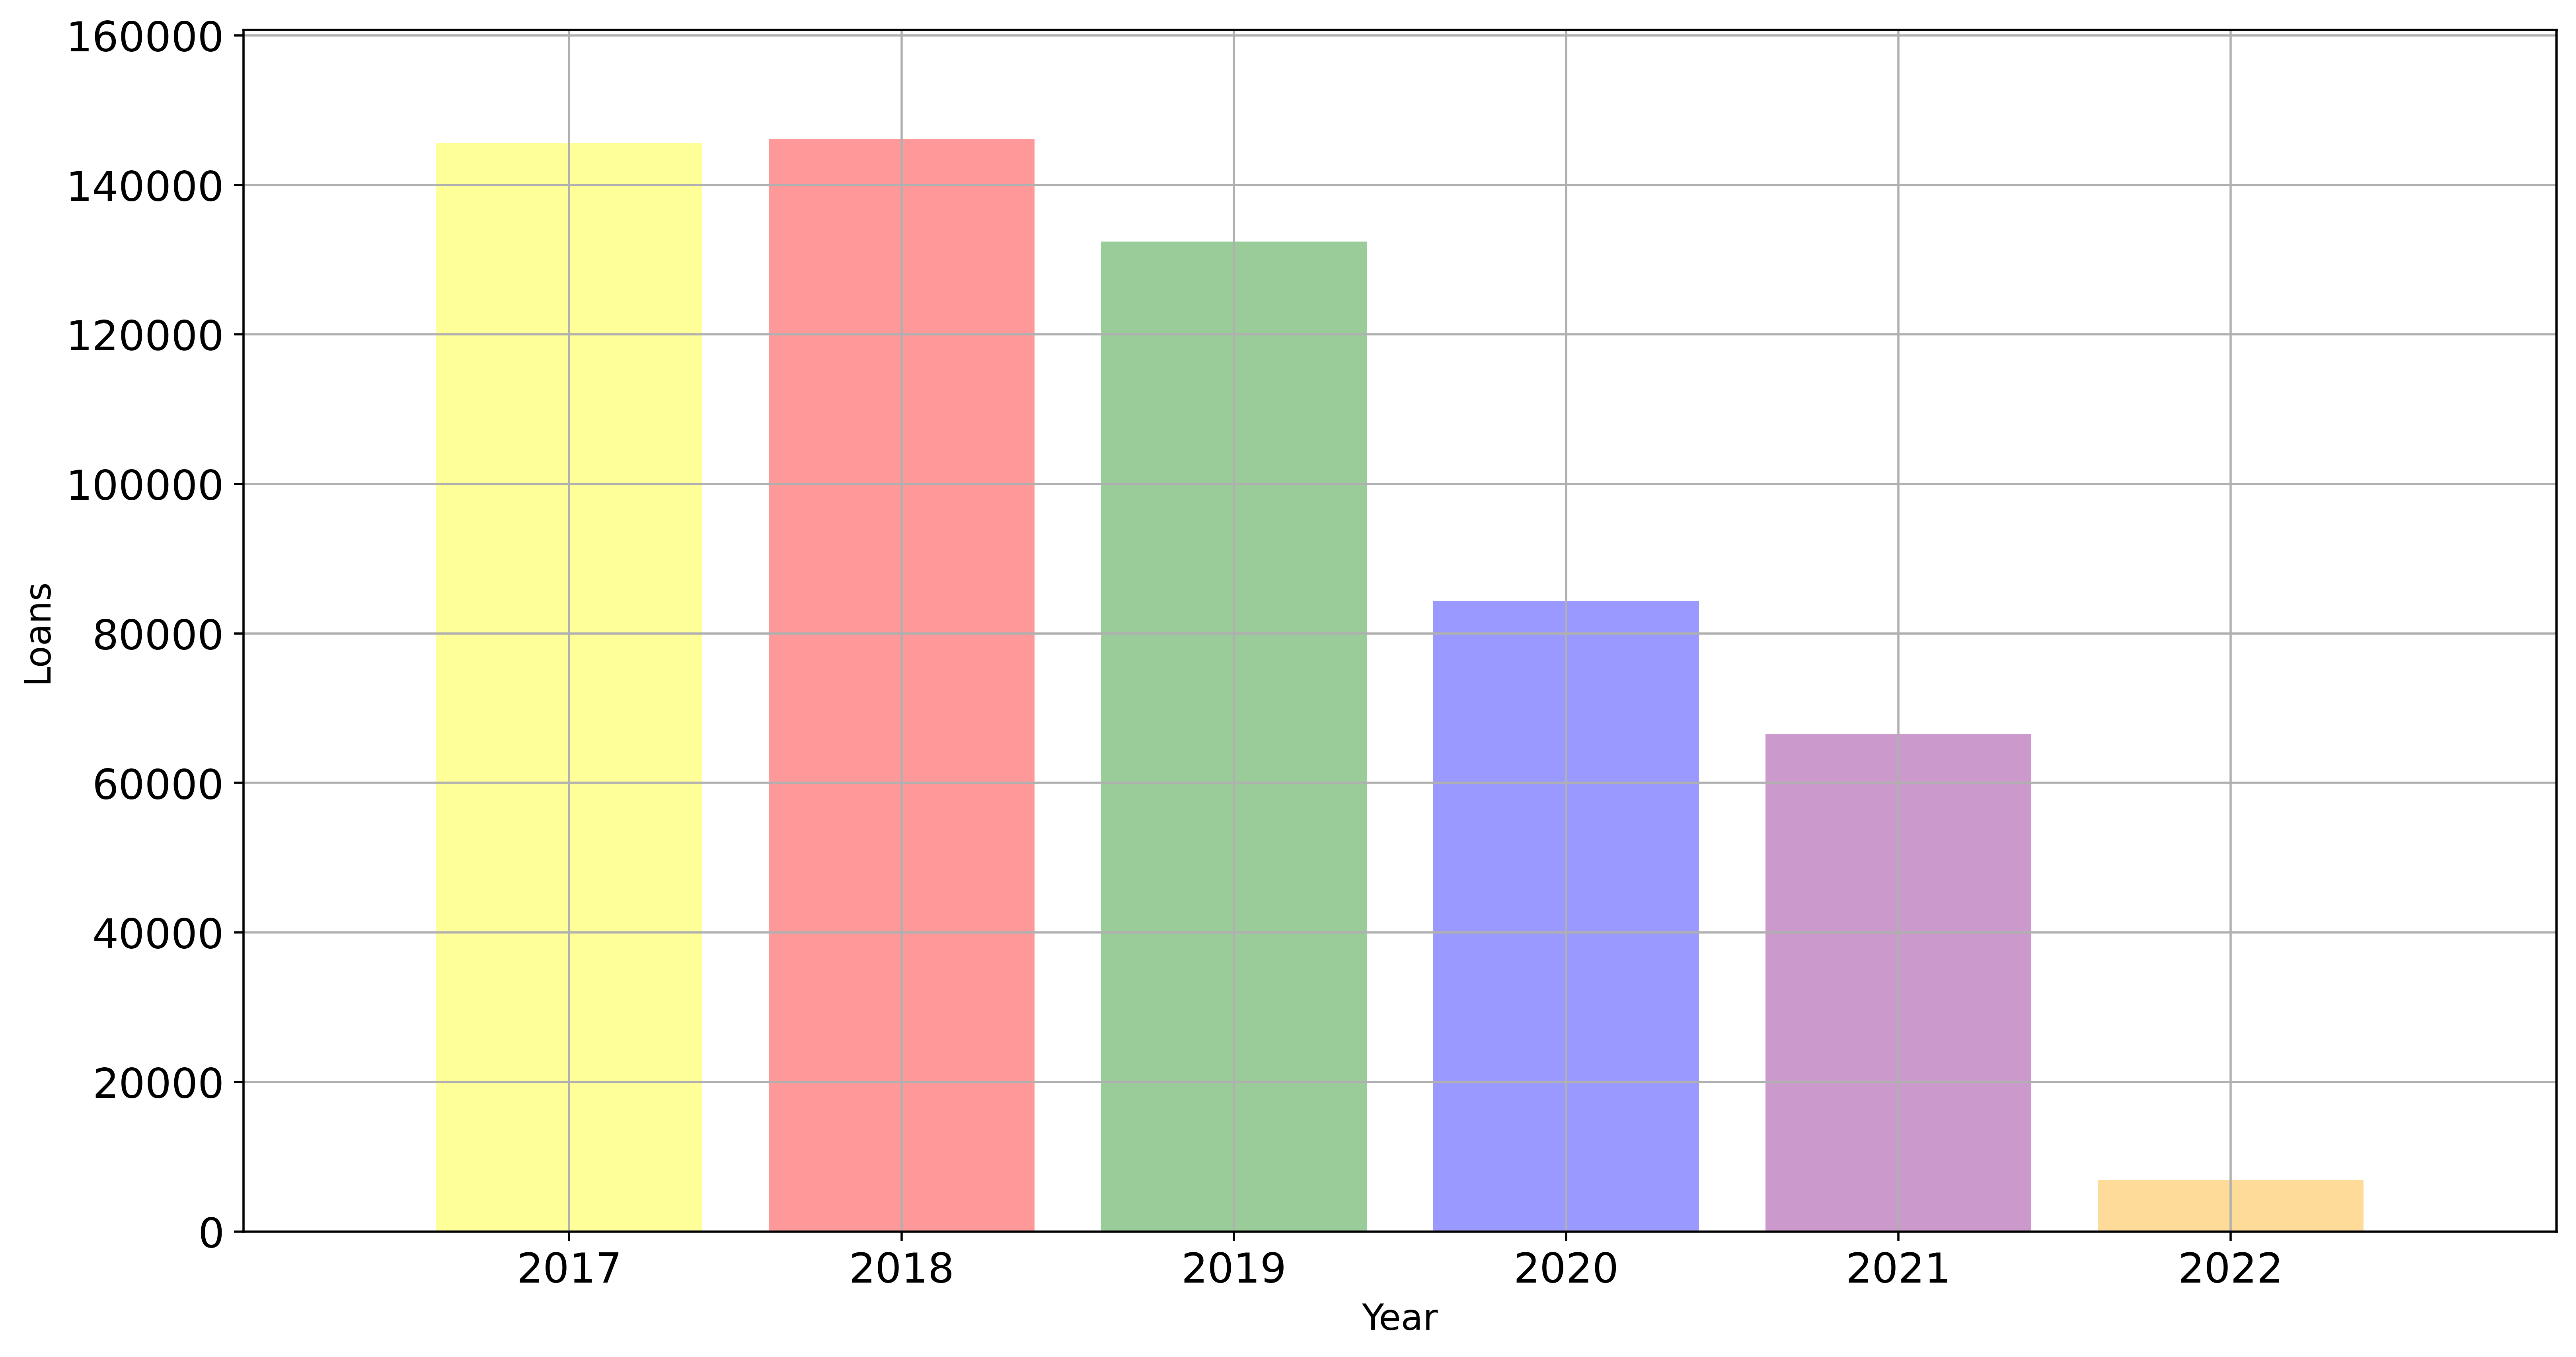

In [ ]:
plt.figure(figsize = (15,8))
plt.bar(b['year'],b['loan'],color = ['red','yellow','green','blue','purple','orange'],alpha = 0.4)
plt.xlabel('Year', size = 13)
plt.ylabel('Loans', size = 13)
plt.show()

## 출판년도, 등록연도 시각화

In [ ]:
def year_credit(s:pd.DataFrame):
    con=[
      (s.astype(int) >= 2017),
      (s.astype(int) >= 2012),
      (s.astype(int) >= 2007),
      (s.astype(int) >= 2002),
      (s.astype(int) >= 1997)
    ]
    r_2=['17-22','12-16','07-11','02-06','97-01']
    return np.select(con, r_2)

In [ ]:
temp = new_df[['year','출판년도']]
temp.columns = ['등록','출판']
temp.reset_index(drop=True,inplace = True)

In [ ]:
temp1 = pd.DataFrame()
temp1['등록'] = year_credit(temp['등록'])
temp1['출판'] = year_credit(temp['출판'])

In [ ]:
df_1 = pd.DataFrame(temp1['출판'].value_counts().reset_index())
df_2 = pd.DataFrame(temp1['등록'].value_counts().reset_index())
df_3 = pd.merge(df_1,df_2,how='left')
df_3.columns = ['연도','출판','등록']
df_3 = df_3.set_index("연도")
df_order = ['17-22','12-16','07-11','02-06','97-01']
df_3 = df_3.loc[df_order]

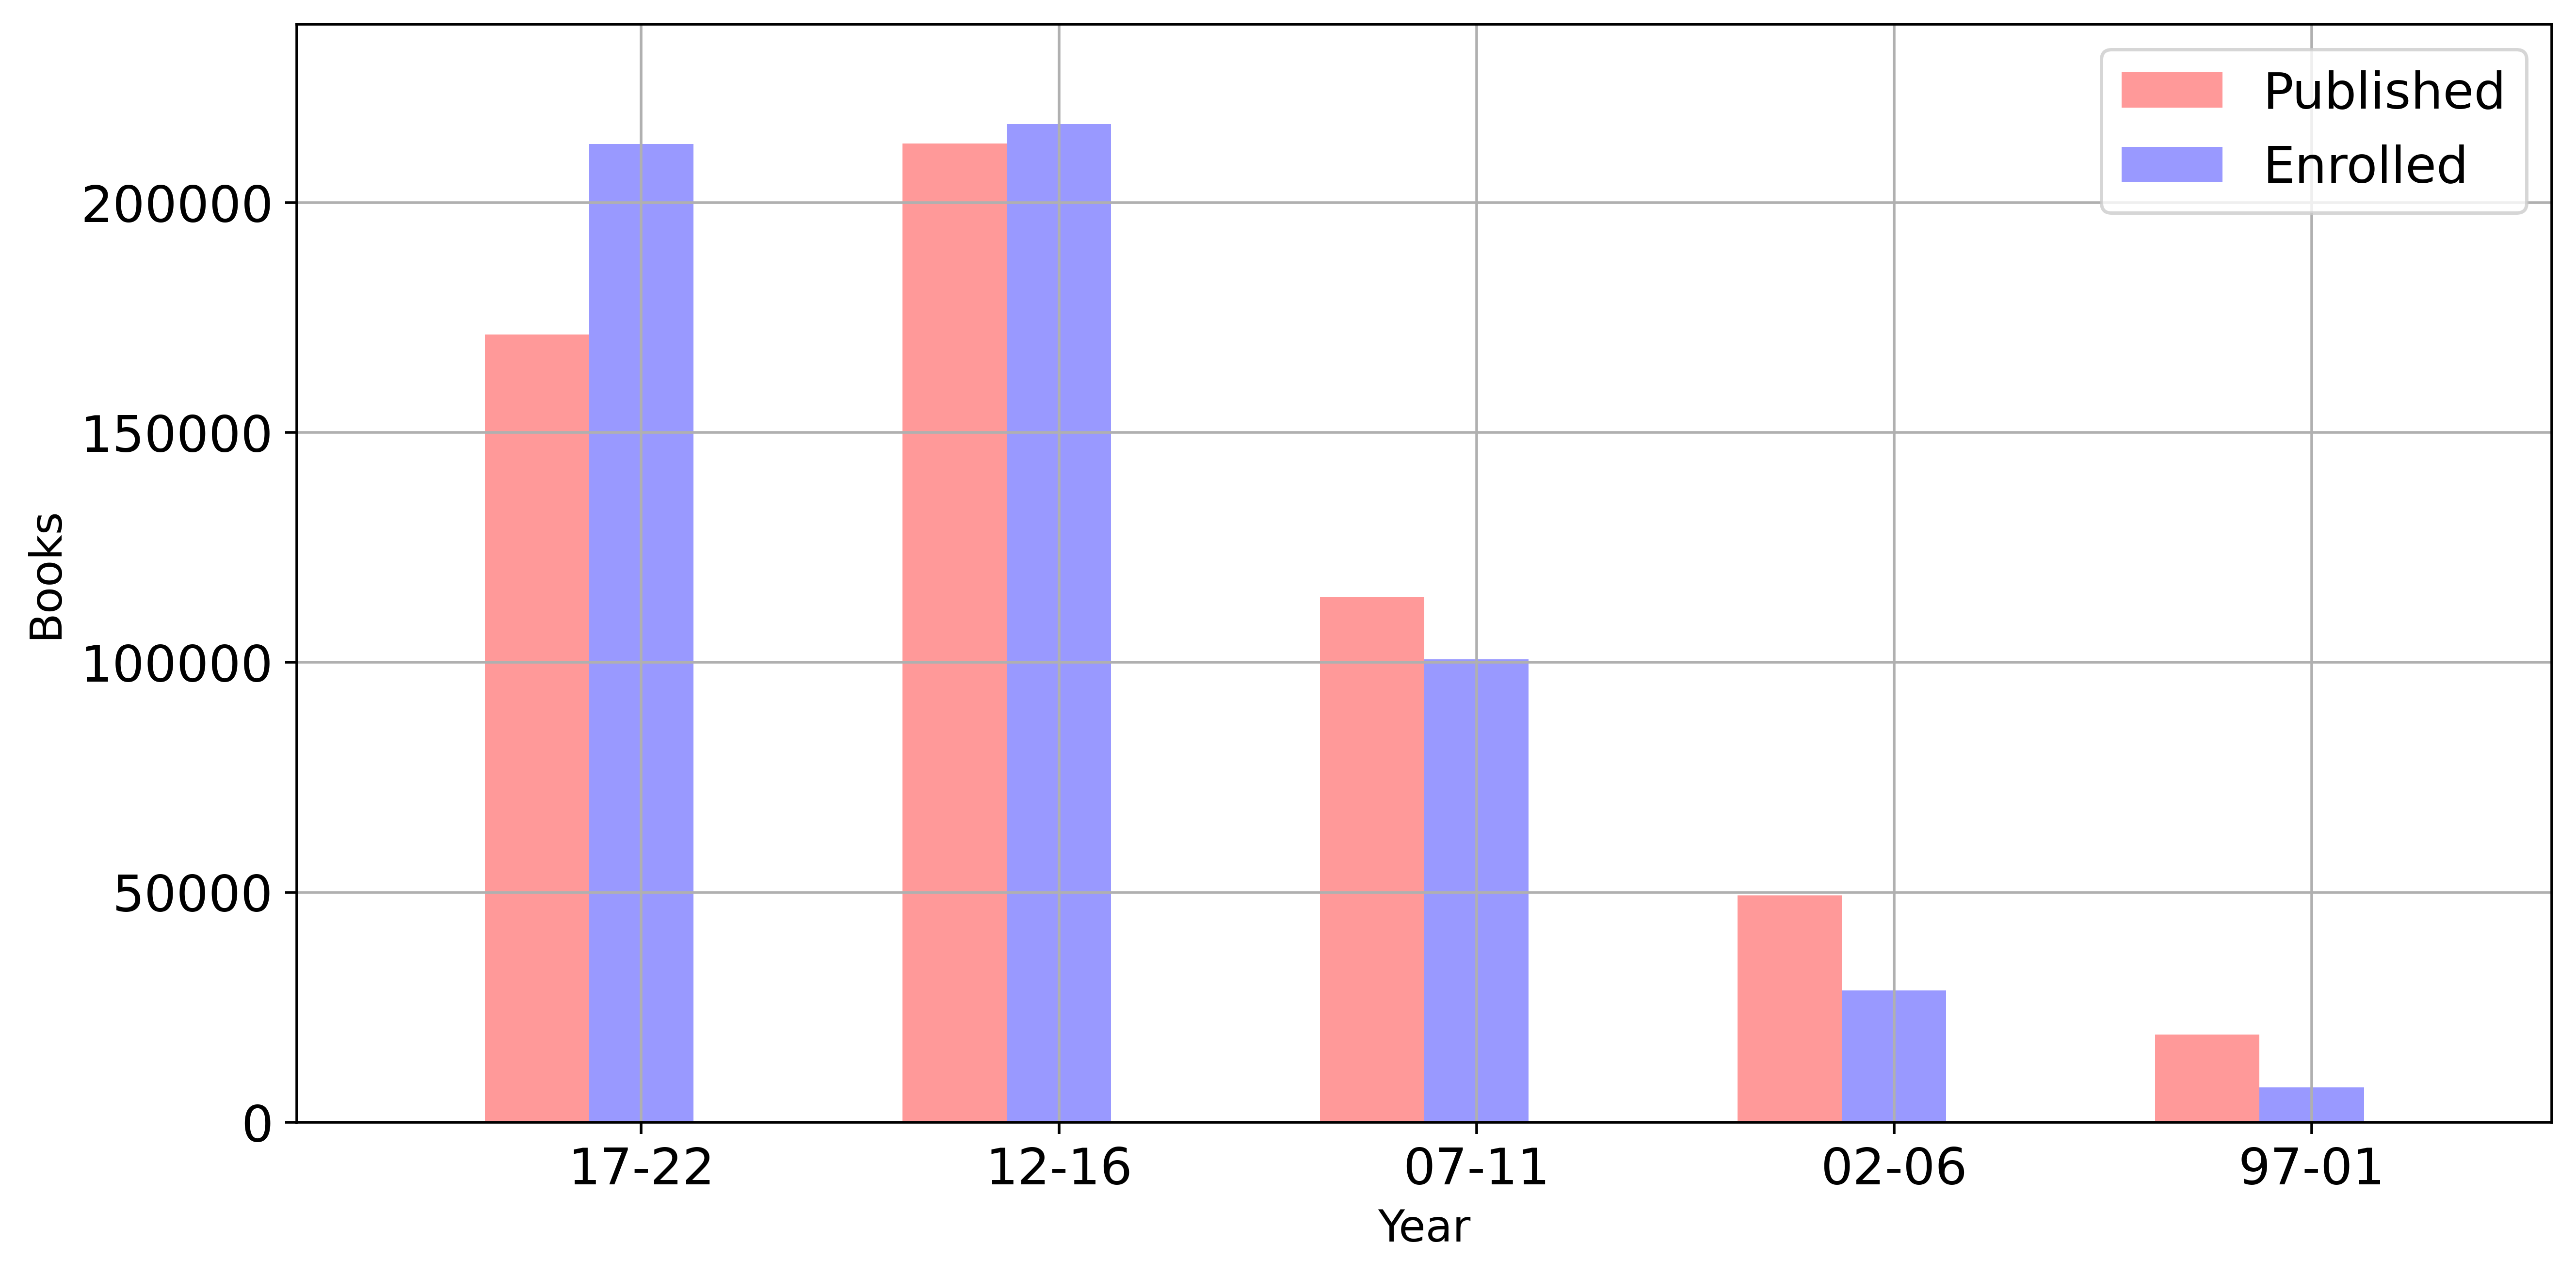

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.25

index = np.arange(5)

b1 = plt.bar(index, df_3['출판'], bar_width, alpha=0.4, color='red', label='Published')

b2 = plt.bar(index + bar_width, df_3['등록'], bar_width, alpha=0.4, color='blue', label='Enrolled')


plt.xticks(np.arange(bar_width, 5 + bar_width, 1), df_order)

plt.xlabel('Year', size = 13)
plt.ylabel('Books', size = 13)
plt.legend()
plt.show()

## 대출과 예약 회귀분석

In [ ]:
#등록번호,서명별 도수표
loan_freq_book = pd.DataFrame(bookloan[['서명','등록번호']].value_counts().reset_index())
loan_freq_book.columns  = ['서명','등록번호','대출']
res_freq_book = pd.DataFrame(bookres[['서명','등록번호']].value_counts().reset_index())
res_freq_book.columns = ['서명', '등록번호','예약']

In [ ]:
#대출 도서, 예약 도수 merge
temp = pd.merge(res_freq_book,loan_freq_book,how = 'left')
#예약 신청은 했지만 대출을 안한 도서 대출 도수 0으로 변경
temp.fillna(0,inplace = True)

In [ ]:
from sklearn.linear_model import LinearRegression

X = temp.예약.values
Y = temp.대출.values
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)
#선형회귀분석
lr = LinearRegression()
lr.fit(X, Y)

LinearRegression()

In [ ]:
#결과표 시각화
import statsmodels.api as sm
results = sm.OLS(Y, sm.add_constant(X)).fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     3334.
Date:                Thu, 11 Aug 2022   Prob (F-statistic):               0.00
Time:                        11:31:41   Log-Likelihood:                -50279.
No. Observations:               13459   AIC:                         1.006e+05
Df Residuals:                   13457   BIC:                         1.006e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3407      0.106     88.435      0.000       9.134       9.548
x1             0.9900      0.017     57.742      0.000       0.956       1.024
==============================================================================
Omnibus:                     3967.649   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15206.389
Skew:                           1.433   Prob(JB):                         0.00
Kurtosis:                       7.348   Cond. No.                         7.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

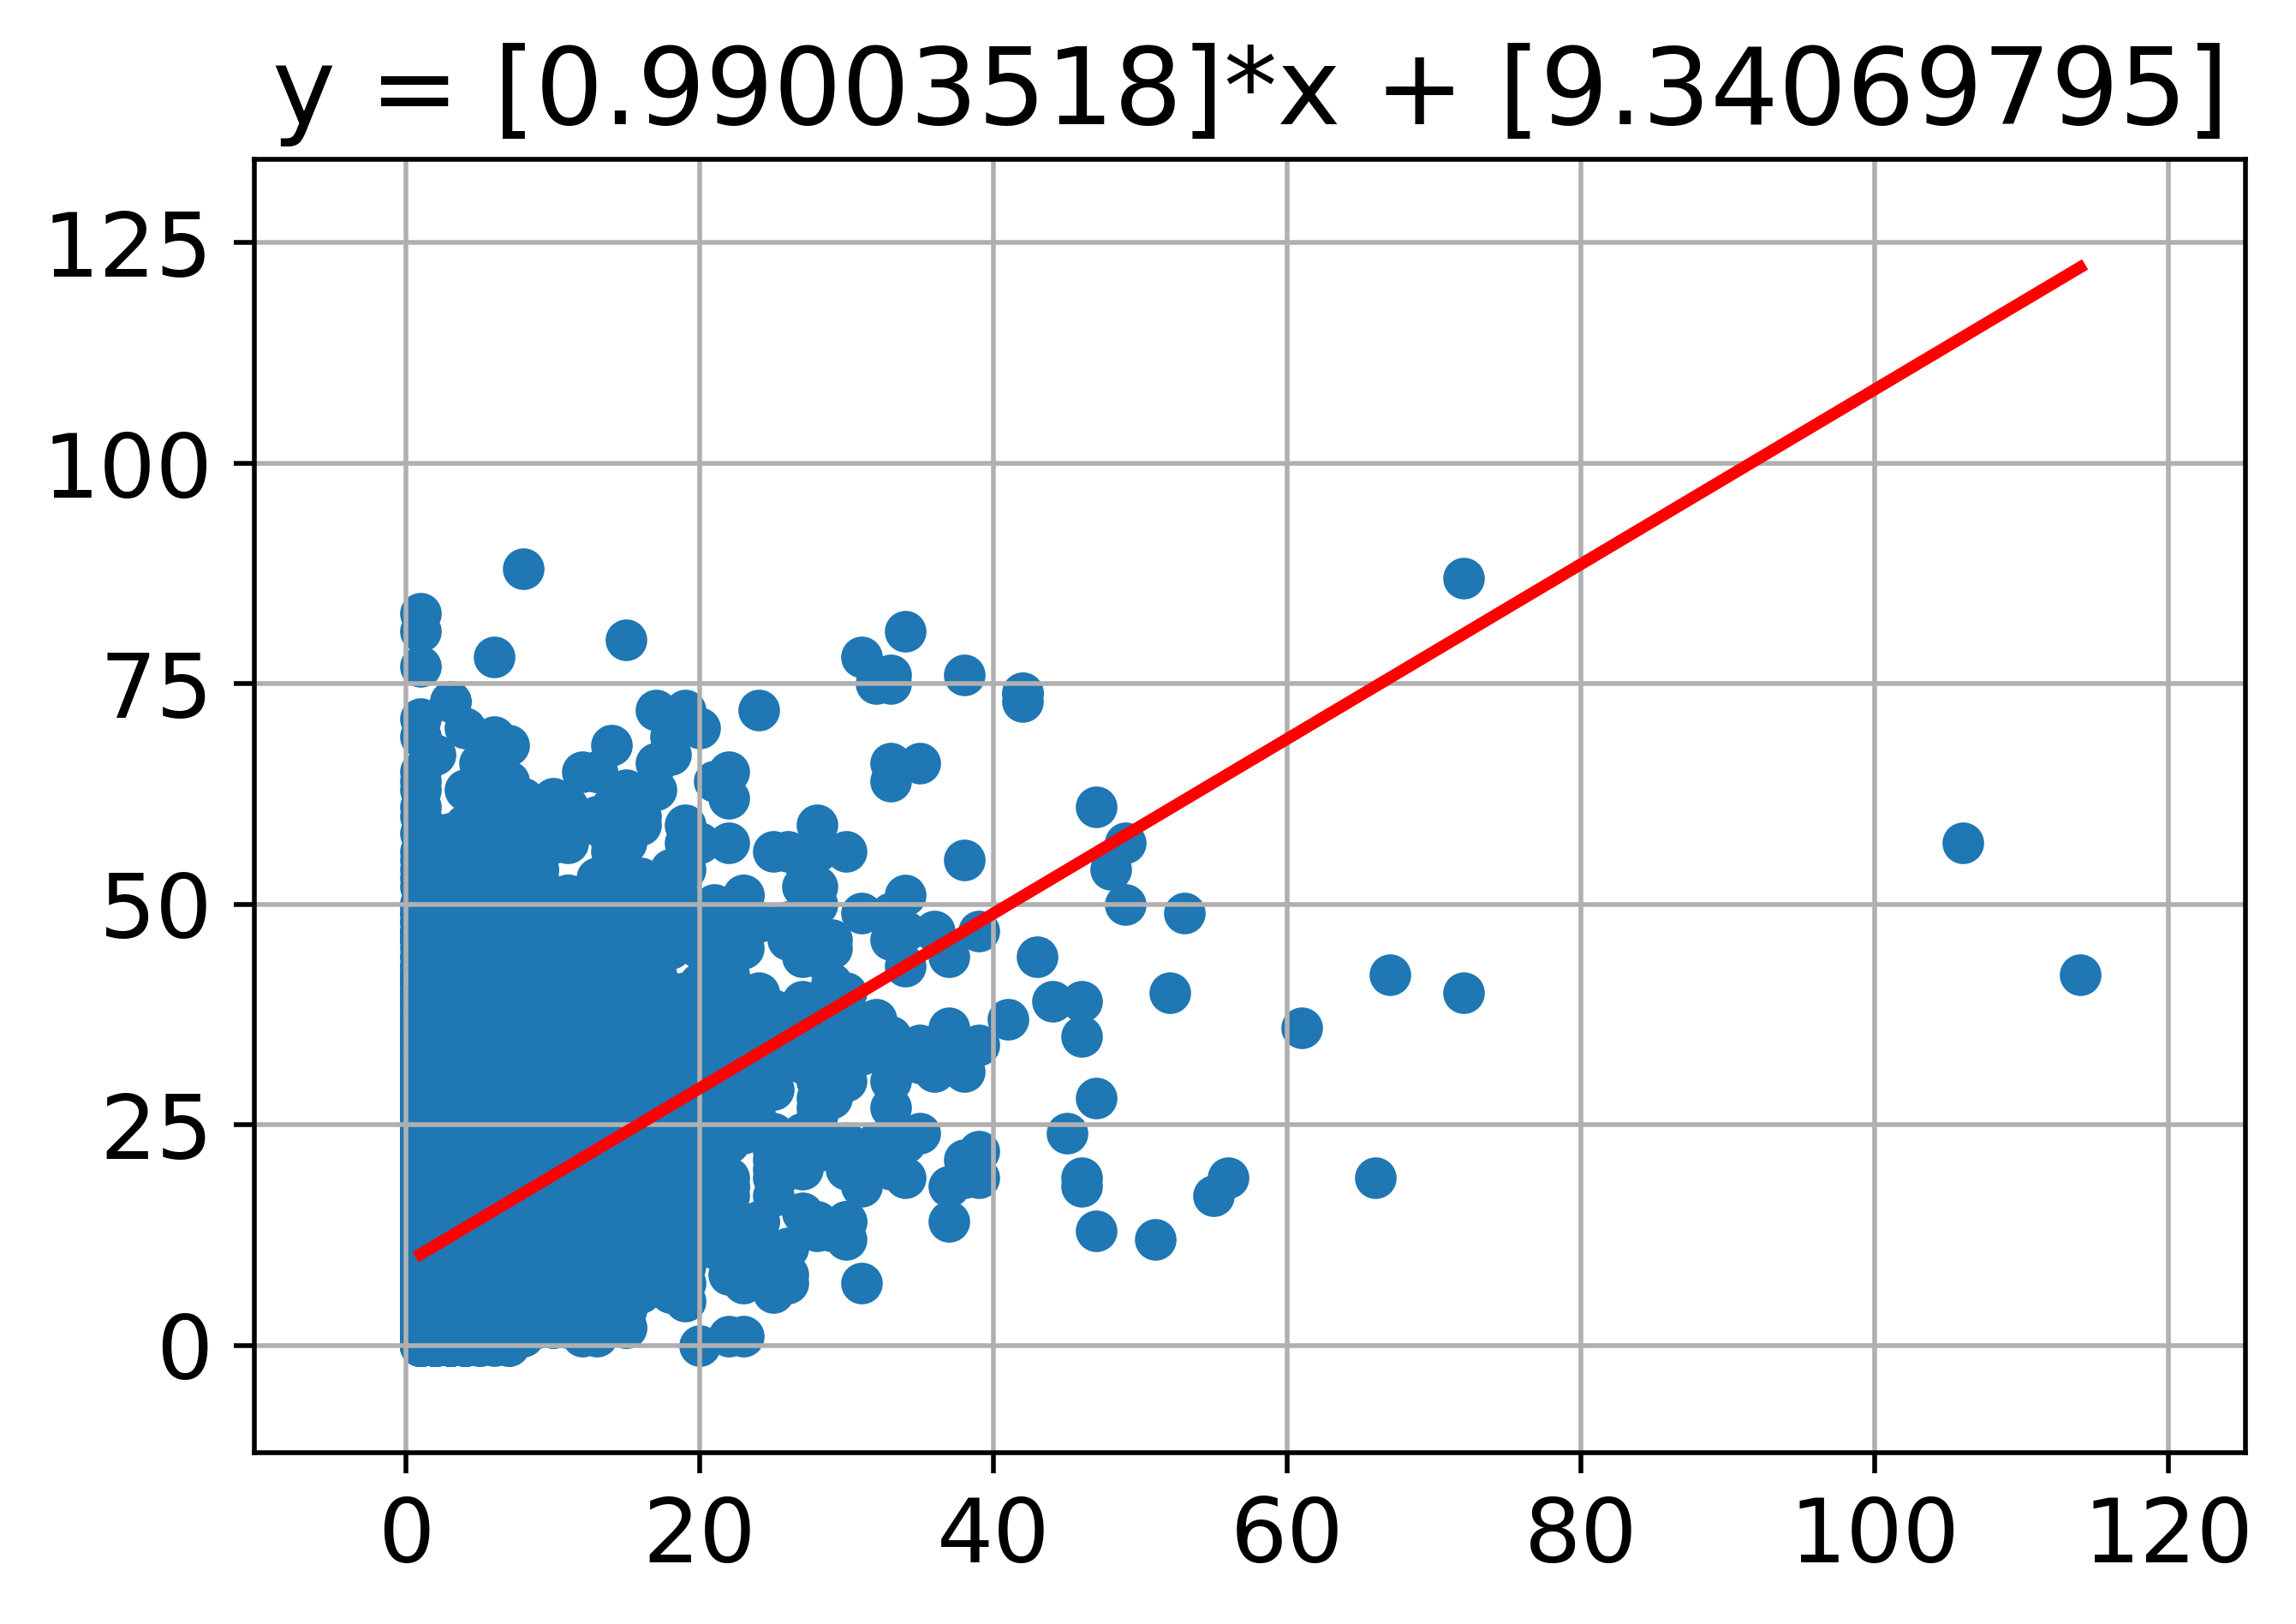

In [ ]:
#산점도 및 회귀추정식 시각화
plt.scatter(X, Y)
Y2 = lr.coef_[0]*X +lr.intercept_
plt.plot(X, Y2, color='red')
plt.title('y = {}*x + {}'.format(lr.coef_[0], lr.intercept_))
plt.show()

## 최종 점수 시각화

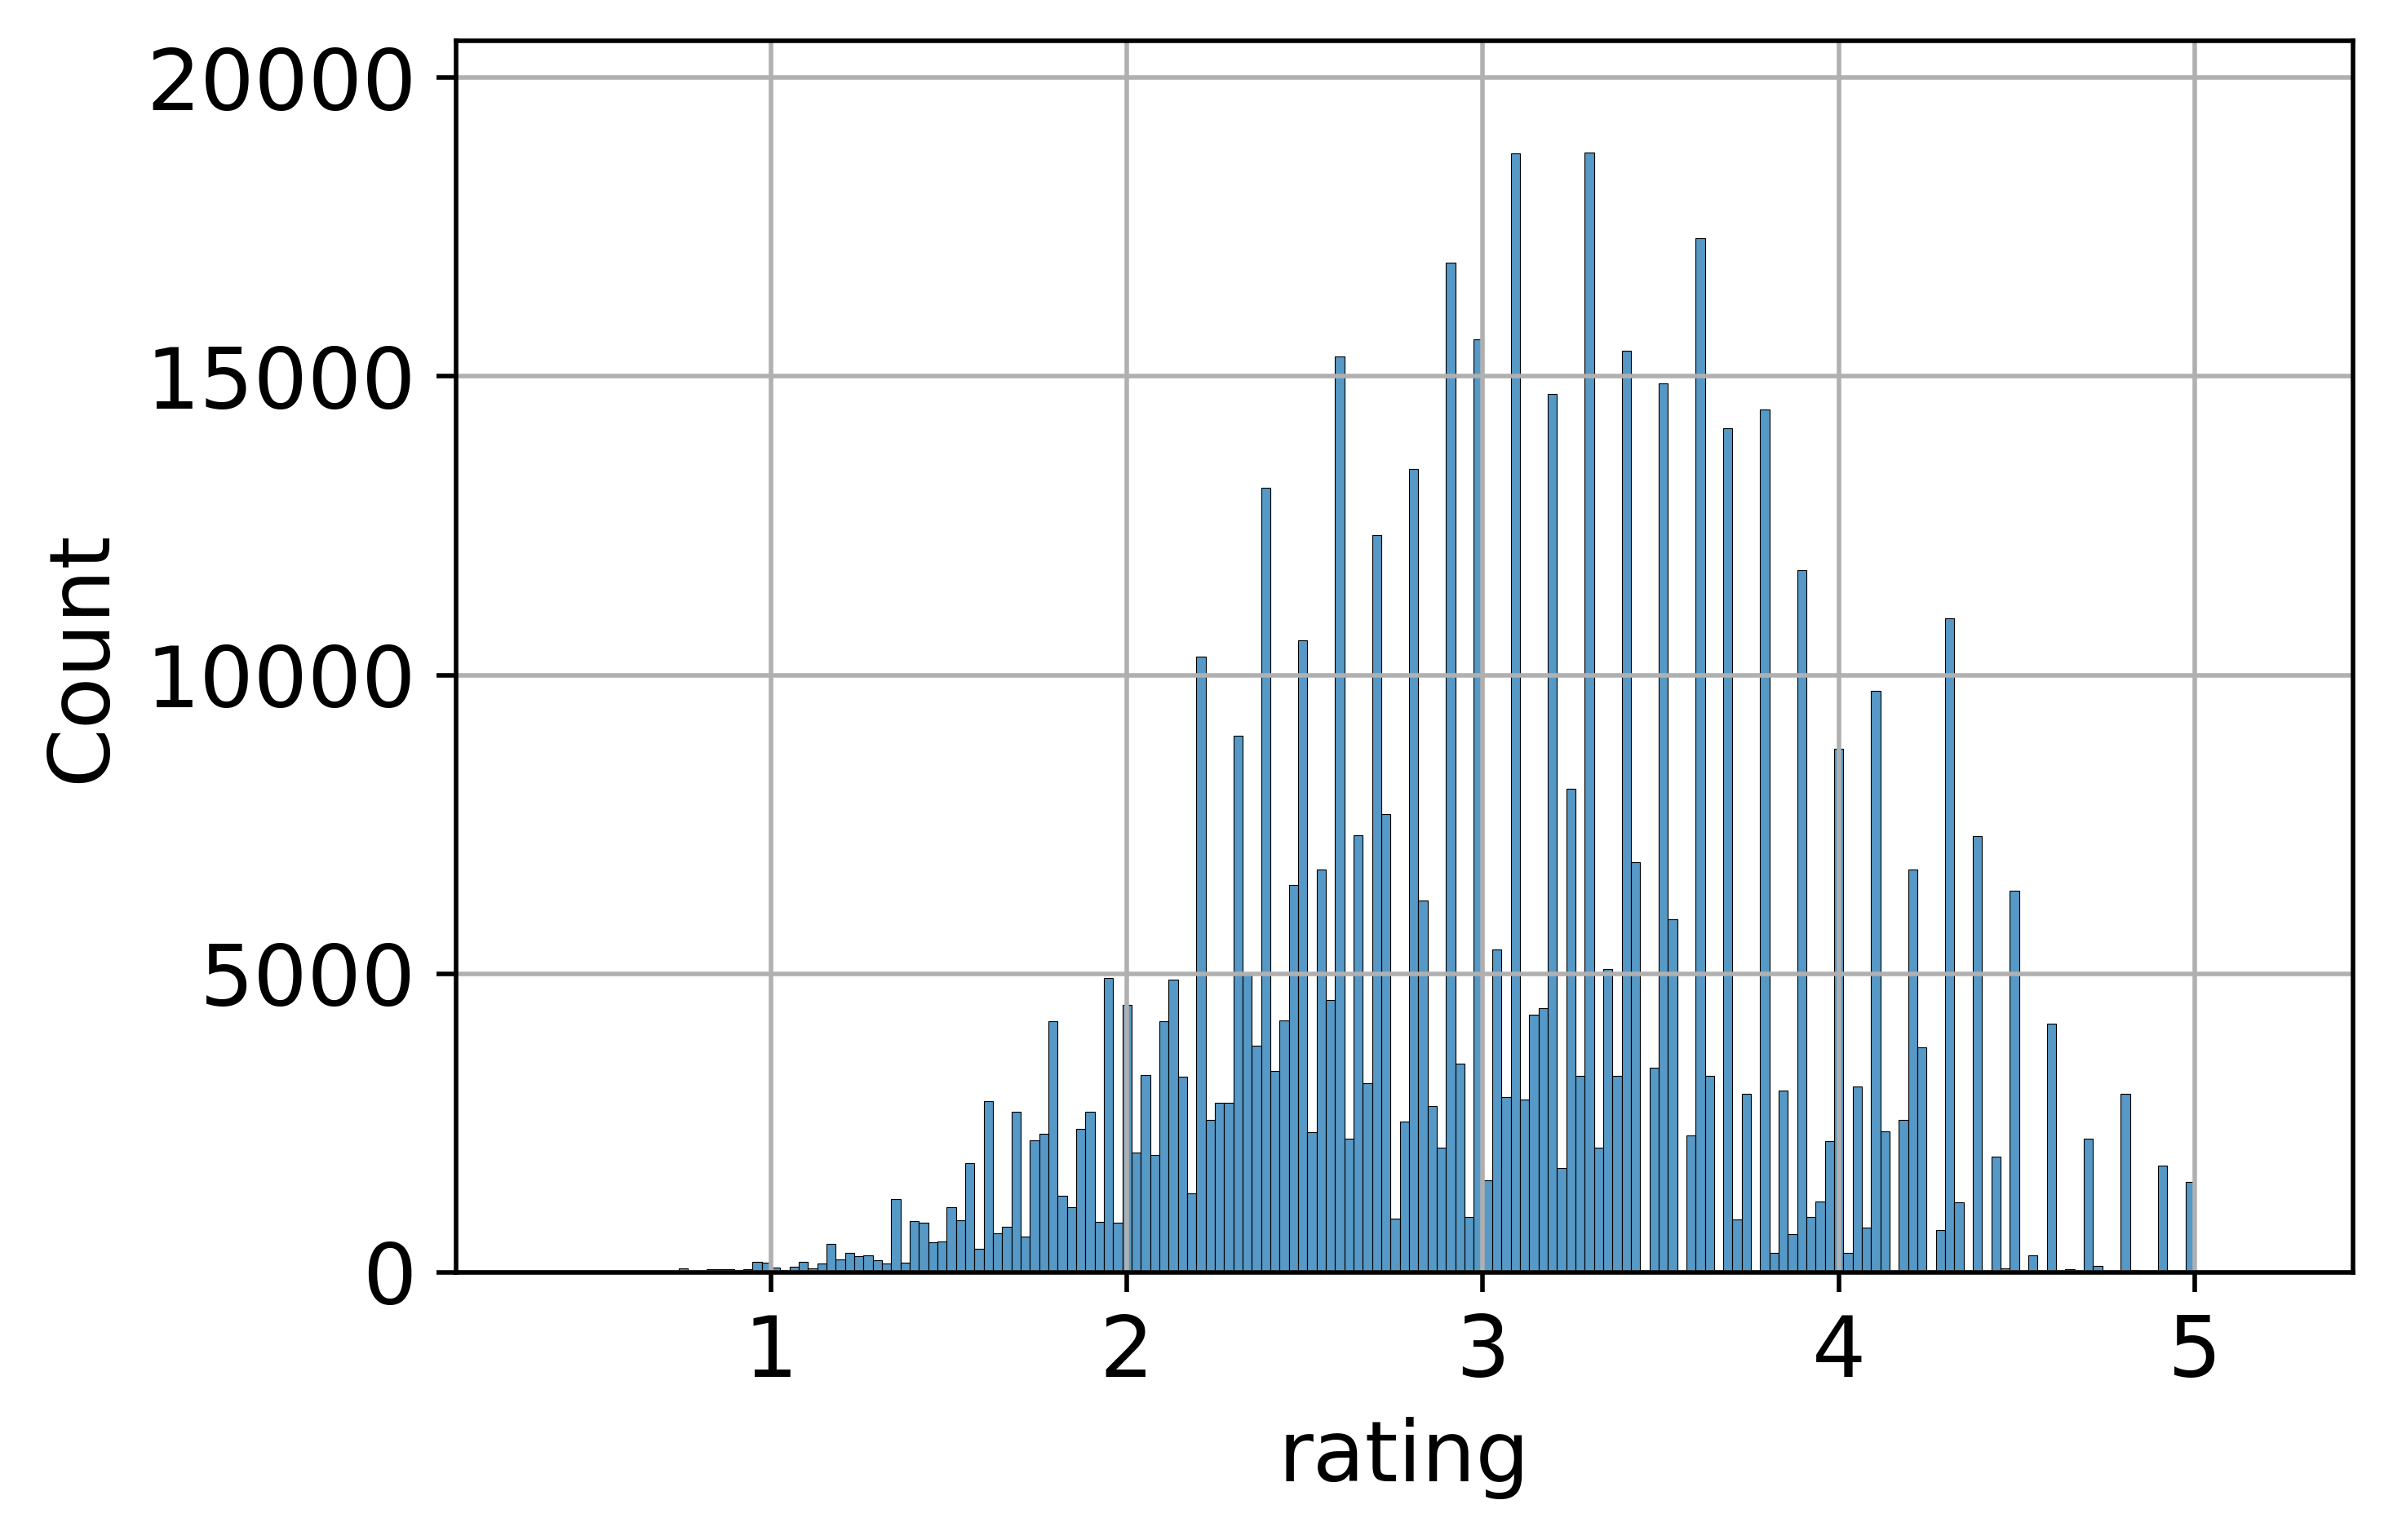

In [ ]:
sns.histplot(uir_df.rating)

## baseline optuna 시각화

In [ ]:
optuna.visualization.plot_optimization_history(model_baseline)

In [ ]:
optuna.visualization.plot_param_importances(model_baseline)

## SVDpp optuna 시각화

In [ ]:
optuna.visualization.plot_optimization_history(model_SVDpp)

In [ ]:
optuna.visualization.plot_param_importances(model_SVDpp)